# MScFE 610 Econometrics (C22-S1) - Groupwork Assignment Submission 2 M5

### Impoting required libraries

In [31]:
import warnings
from IPython.display import Image
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 20,10

### Step 0: Selecting a data set

For gold ETF, we choose SPDR Gold Trust (GLD) and for non-US equity ETF, we choose: iShares MSCI Emerging Markets ETF (EEM). We also pull data for Grayscale Bitcoin Trust (GBTC).

### Step 1: Data Importing

We consider three time points for splitting the pulled data:

In [3]:
Jan20 = dt.datetime(2020,1,1)
Apr20 = dt.datetime(2020,4,1)
Jul20 = dt.datetime(2020,7,1)
Oct20 = dt.datetime(2020,10,1)
Jan21 = dt.datetime(2021,1,1)

#### Gold ETF (GLD):

In [4]:
GLD = yf.download('GLD',start = Jan20, end = Jan21,  progress = False)
GLD[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,148.199997,150.080002,147.850006,149.449997,149.449997,11827400
2020-04-02,151.199997,152.500000,150.699997,151.899994,151.899994,9188300
2020-04-03,152.229996,153.089996,151.660004,152.649994,152.649994,8469100
2020-04-06,154.160004,157.220001,153.960007,156.880005,156.880005,14739300
2020-04-07,155.330002,156.139999,154.380005,156.039993,156.039993,9195400


In [5]:
GLD = GLD['Adj Close']

#### Emerging Markets ETF (EEM):

In [6]:
EEM = yf.download('EEM', start = Jan20, end = Jan21, progress = False)
EEM[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,33.099998,33.330002,32.619999,32.669998,31.540220,65580600
2020-04-02,33.290001,33.939999,33.200001,33.770000,32.602184,55784000
2020-04-03,33.689999,33.860001,32.950001,33.130001,31.984318,68672500
2020-04-06,34.439999,34.950001,34.299999,34.939999,33.731720,82394800
2020-04-07,36.090000,36.119999,35.049999,35.119999,33.905499,74322600


In [7]:
EEM = EEM['Adj Close']

#### Bitcoin (BTC):

In [8]:
GBTC = yf.download('GBTC', start = Jan20, end = Jan21, progress = False)
GBTC[Apr20:Jan21].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,6.800,6.90,6.41,6.495,6.495,4274800
2020-04-02,7.000,7.87,6.98,7.720,7.720,7980600
2020-04-03,7.940,7.94,7.25,7.480,7.480,3059800
2020-04-06,7.824,8.06,7.71,7.950,7.950,4910400
2020-04-07,8.070,8.15,7.61,7.660,7.660,3469900


In [9]:
GBTC = GBTC['Adj Close']

#### Integrating the data

In [10]:
data = pd.DataFrame({'EEM':EEM, 'GLD':GLD, 'GBTC':GBTC})
data[Apr20:Jan21].head()

,EEM,GLD,GBTC
Date,,,
2020-04-01,31.540220,149.449997,6.495
2020-04-02,32.602184,151.899994,7.720
2020-04-03,31.984318,152.649994,7.480
2020-04-06,33.731720,156.880005,7.950
2020-04-07,33.905499,156.039993,7.660


In [11]:
data.isnull().any()

EEM     False
GLD     False
GBTC    False
dtype: bool

In [12]:
data_Q2 = data[Apr20:Jul20]
data_Q3 = data[Jul20:Oct20]
data_Q4 = data[Oct20:Jan21]

### Step 2: Data Processing

Compute the daily returns of your gold ETF, your Equity ETF, and bitcoin of April 2020 through Dec 2020

In [13]:
data['GLD_lr'] = np.log(data['GLD']).diff()
data['EEM_lr'] = np.log(data['EEM']).diff()
data['GBTC_lr'] = np.log(data['GBTC']).diff()
data[Apr20:Jan21].head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr
Date,,,,,,
2020-04-01,31.540220,149.449997,6.495,0.009412,-0.043720,-0.091875
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582
2020-04-06,33.731720,156.880005,7.950,0.027334,0.053193,0.060939
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005139,-0.037160


### Step 3: Data Summaries

In [14]:
data['EEM_MA20'] = data['EEM'].rolling(window=20).mean()
data['GLD_MA20'] = data['GLD'].rolling(window=20).mean()
data['GBTC_MA20'] = data['GBTC'].rolling(window=20).mean()
data = data[Apr20:Jan21]
data.head()

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,
2020-04-01,31.540220,149.449997,6.495,0.009412,-0.043720,-0.091875,33.350866,149.164499,7.5127
2020-04-02,32.602184,151.899994,7.720,0.016261,0.033116,0.172782,33.003316,148.884998,7.3522
2020-04-03,31.984318,152.649994,7.480,0.004925,-0.019134,-0.031582,32.665419,148.639998,7.1972
2020-04-06,33.731720,156.880005,7.950,0.027334,0.053193,0.060939,32.547155,148.593498,7.1512
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005139,-0.037160,32.345865,148.671498,7.0712


### Step 4: Graphing

In this section, we graph both prices and moving averages of the financial products and provide some simple technical discussion

Text(0,0.5,'Price (USD)')

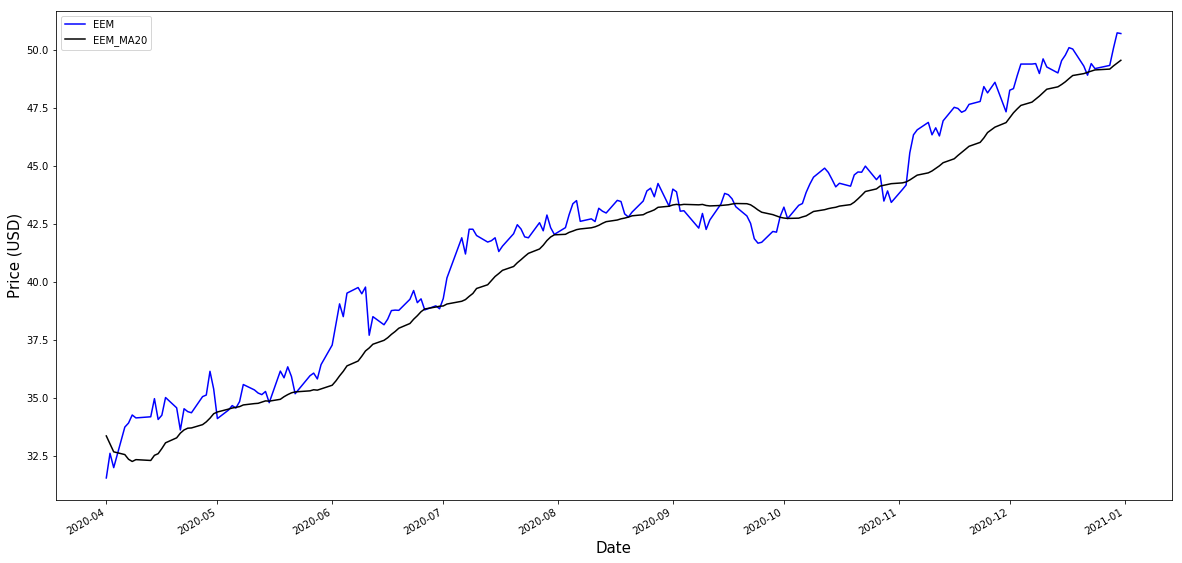

In [15]:
ax1 = data[['EEM','EEM_MA20']].plot(color = ['blue','black'])
ax1.set_xlabel('Date', size=15)
ax1.set_ylabel('Price (USD)', size=15)

For EEM, the moving average has basically acted as up-trend support and we have only short-duration of crossing of the price and moving average.

Text(0,0.5,'Price (USD)')

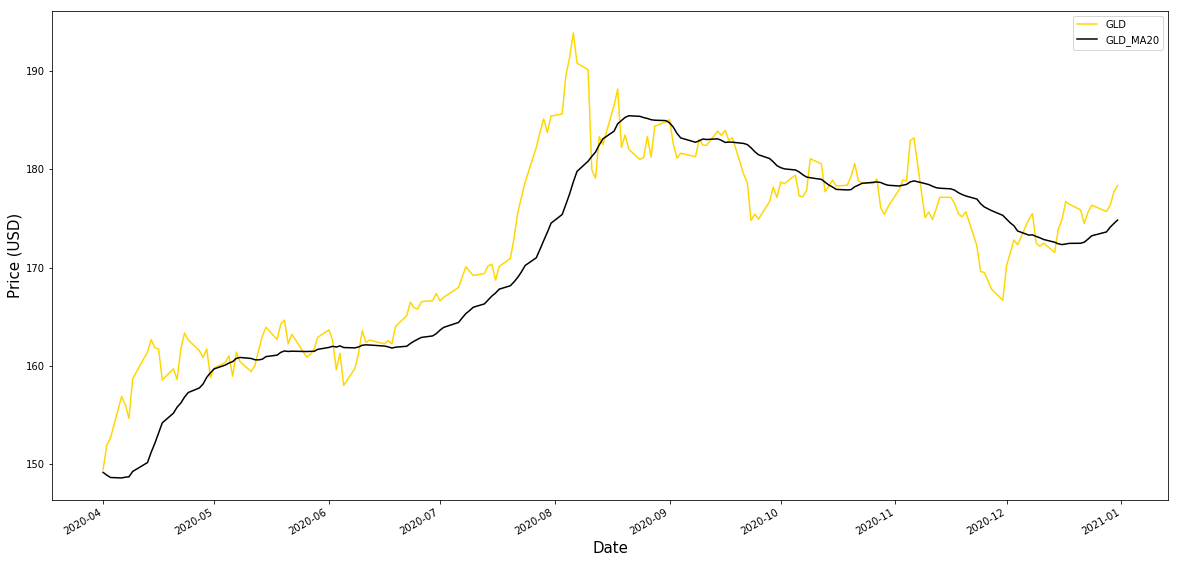

In [16]:
ax2 = data[['GLD','GLD_MA20']].plot(color = ['gold','black'])
ax2.set_xlabel('Date', size=15)
ax2.set_ylabel('Price (USD)', size=15)

For GLD, the moving average has acted as up-trend support till mid-Aug and we have then a major crossing of the price and moving average which has lead to a sideways/down-trend price action.

Text(0,0.5,'Price (USD)')

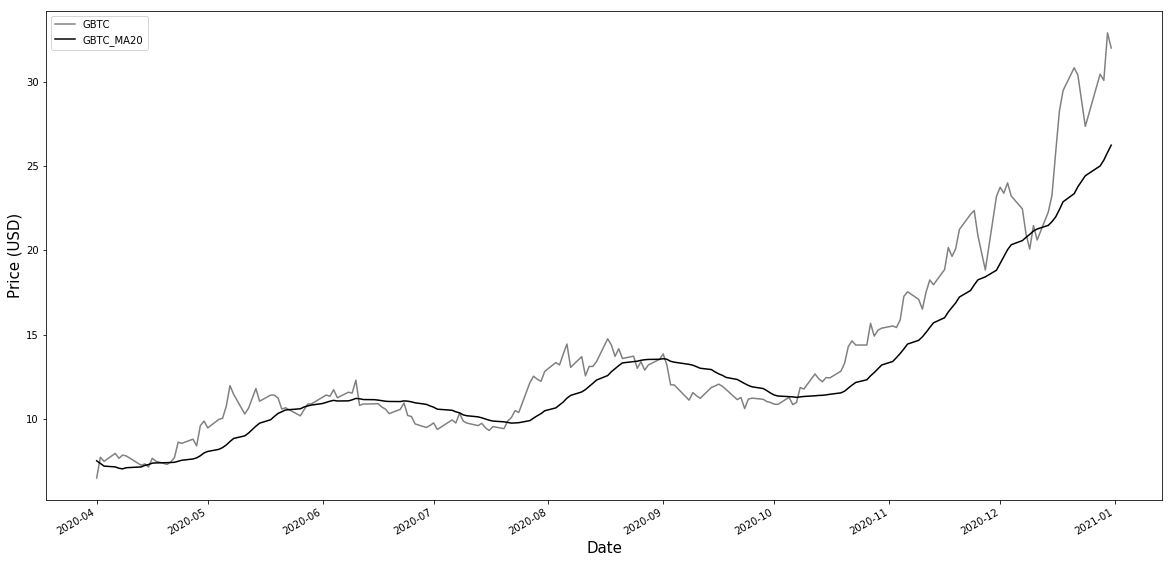

In [17]:
ax3 = data[['GBTC','GBTC_MA20']].plot(color = ['gray','black'])
ax3.set_xlabel('Date', size=15)
ax3.set_ylabel('Price (USD)', size=15)

For GBTC, we have alternate crossing of the moving average and price till Oct which describes a sideways price action by then. However, after Oct, we have a major uptrend and no significant crossing in the continuation.

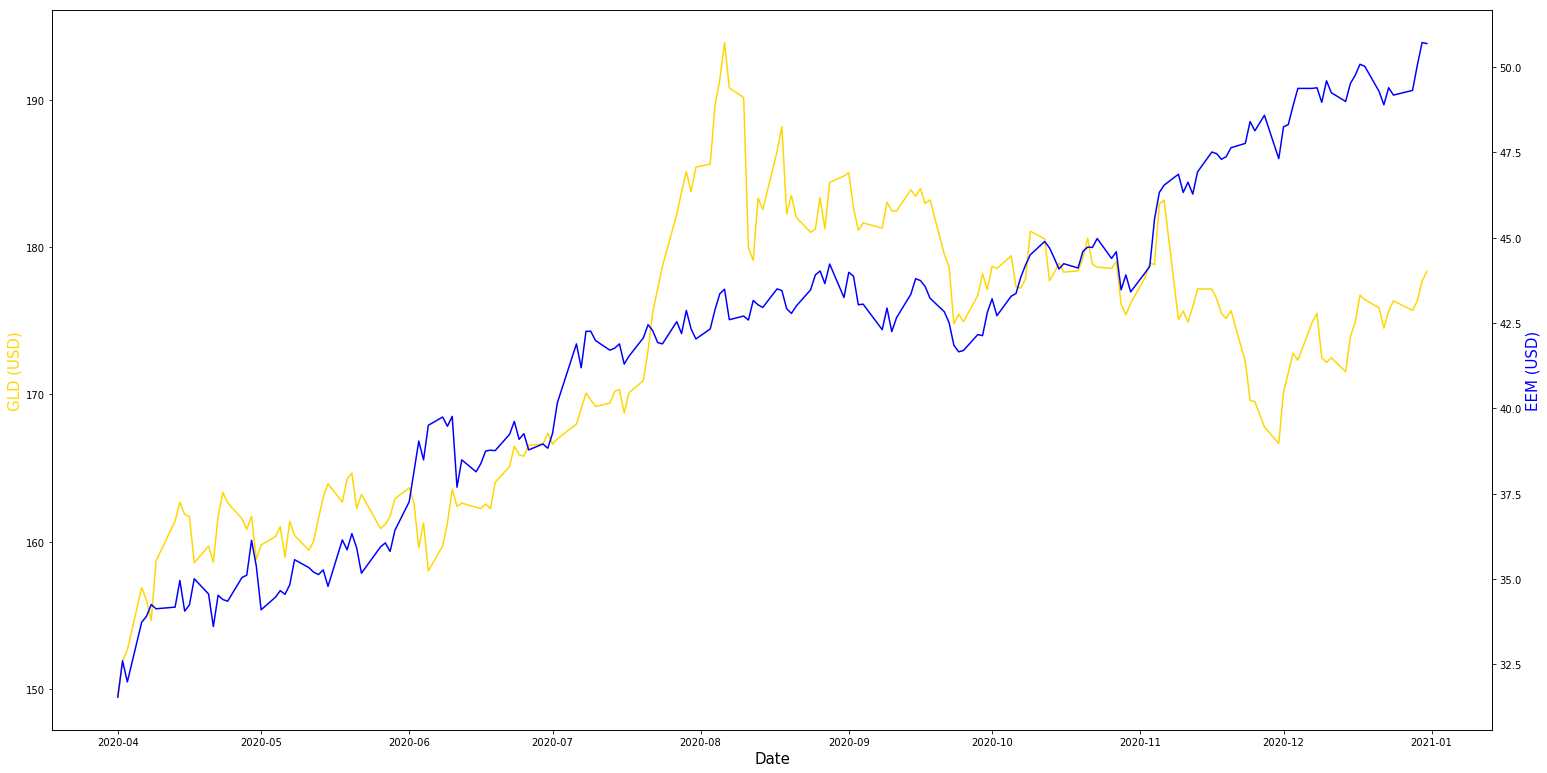

In [18]:
fig1 = plt.figure()
ax4 = fig1.add_axes([.1,.1,1,1])
ax4.plot(data.index, data.GLD,  color='gold')
ax4.set_xlabel('Date', size = 15)
ax4.set_ylabel('GLD (USD)', size=15, color='gold')
ax4_2 = ax4.twinx()
ax4_2.plot(data.index, data.EEM, color='blue')
ax4_2.set_ylabel('EEM (USD)', size=15, color='blue')
plt.show()

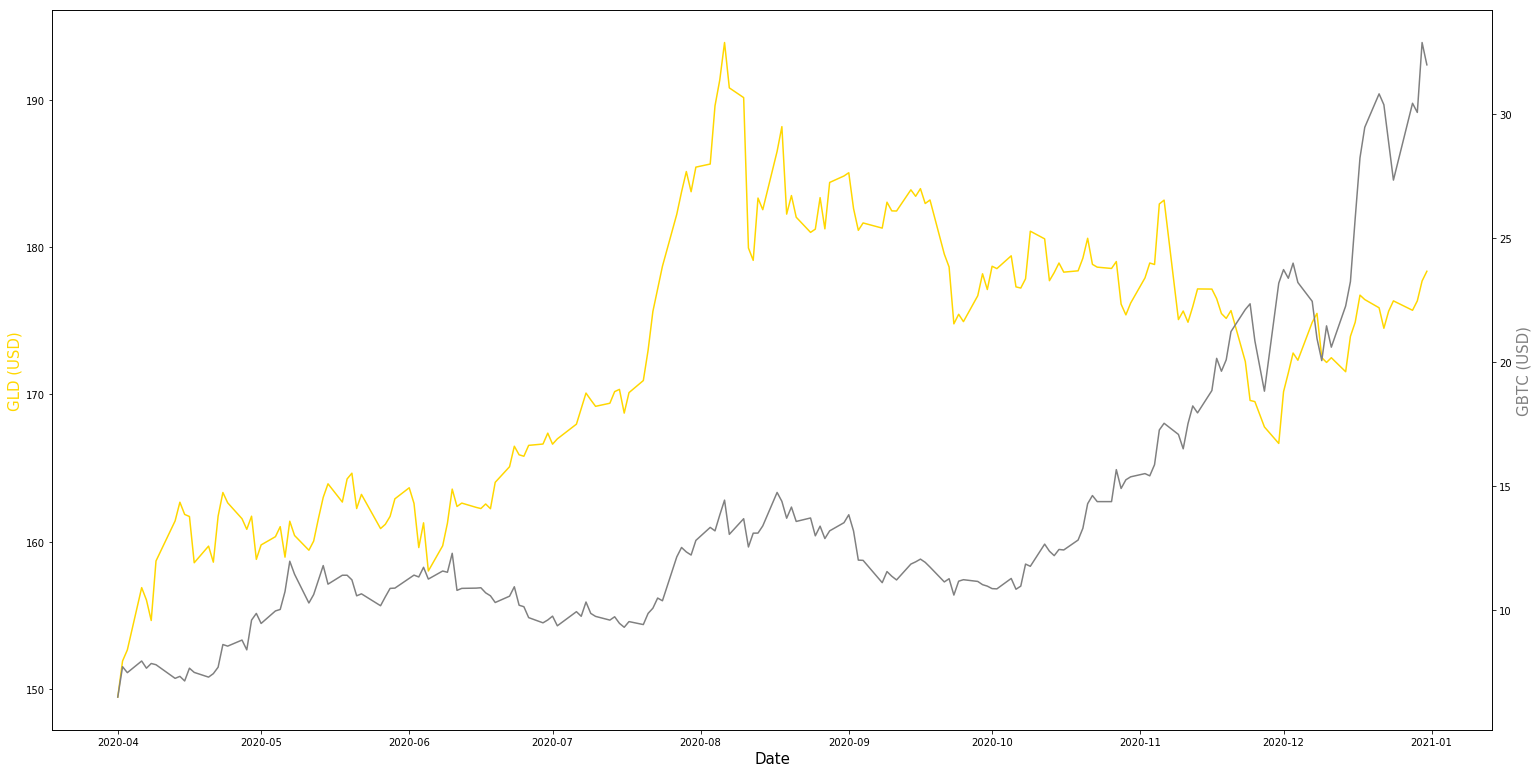

In [19]:
fig2 = plt.figure()
ax5 = fig2.add_axes([.1,.1,1,1])
ax5.plot(data.index, data.GLD,  color='gold')
ax5.set_xlabel('Date', size = 15)
ax5.set_ylabel('GLD (USD)', size=15, color='gold')
ax5_2 = ax5.twinx()
ax5_2.plot(data.index, data.GBTC, color='gray')
ax5_2.set_ylabel('GBTC (USD)', size=15, color='gray')
plt.show()

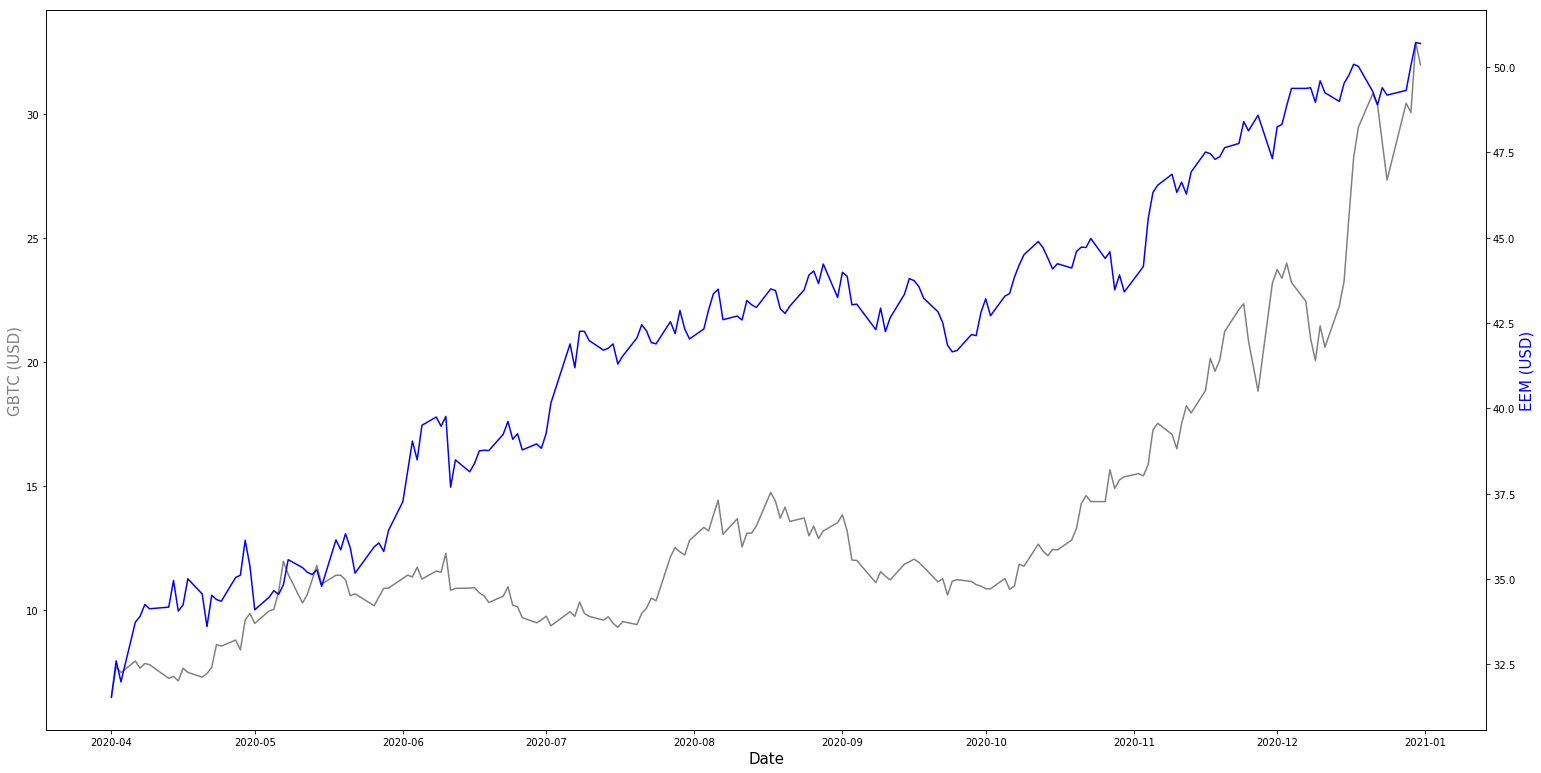

In [20]:
fig3 = plt.figure()
ax6 = fig3.add_axes([.1,.1,1,1])
ax6.plot(data.index, data.GBTC,  color='gray')
ax6.set_xlabel('Date', size = 15)
ax6.set_ylabel('GBTC (USD)', size=15, color='gray')
ax6_2 = ax6.twinx()
ax6_2.plot(data.index, data.EEM, color='blue')
ax6_2.set_ylabel('EEM (USD)', size=15, color='blue')
plt.show()

### Step 5: Fitting a GARCH Model

We choose to model the gold (GLD) volatility using GARCH models. We consider the time-series returns to fit the GARCH model which is stationary:

In [38]:
series = data['GLD_lr']
p_value = adfuller(series)[1]
print(f'the ADF p_value for GLD in Q1 is: {p_value}')

the ADF p_value for GLD in Q1 is: 1.5183418013593368e-12


### GARCH

First, we try estimating the model orders using ACF/PACF:

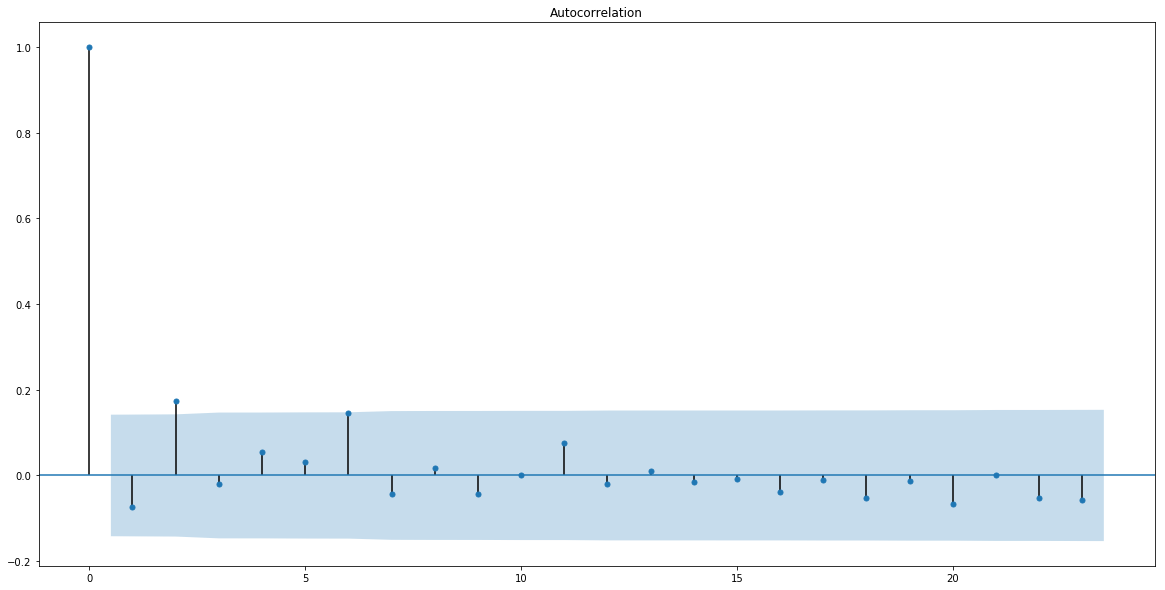

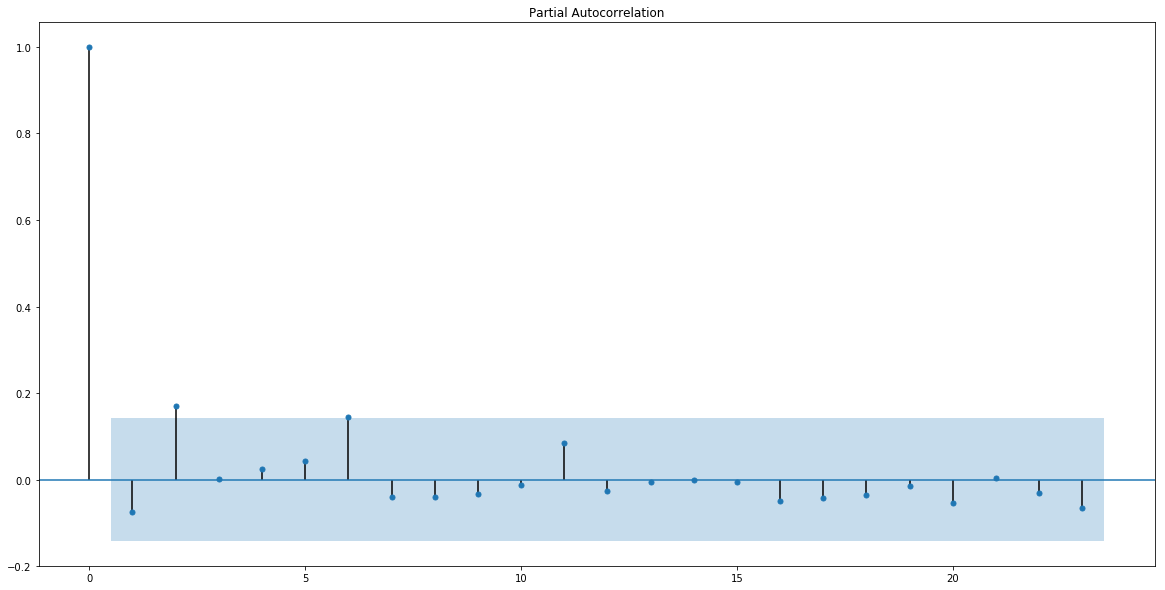

In [21]:
series = data['GLD_lr'] - data['GLD_lr'].mean()
plot_acf(series**2)
plt.show()
plot_pacf(series**2)
plt.show()

Based on the ACF/PACF plots, we see minimal lagged correlations. So, we choose GARCH(1,1) models.

#### Q2 modeling:

In [22]:
data_Q2 = data[Apr20:Jul20]
data_Q3 = data[Jul20:Oct20]
data_Q4 = data[Oct20:Jan21]

In [23]:
series_Q2 = data_Q2['GLD_lr']-data_Q2['GLD_lr'].mean()
model_Q2 = arch_model(series_Q2, p=1, q=1)
model_Q2.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.625074722029908e+16
Iteration:      2,   Func. Count:     17,   Neg. LLF: 171433213.5436107
Iteration:      3,   Func. Count:     29,   Neg. LLF: -204.03211774378994
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.03211831241742
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                204.032
Distribution:                  Normal   AIC:                          -400.064
Method:            Maximum Likelihood   BIC:                          -391.429
                                        No. Observations:                   64
Date:                Thu, Apr 21 2022   Df Residuals:                       63
Time:                        15:16:58   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -5.6452e-04  3.333e-06   -169.364      0.000 [-5.710e-04,-5.580e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0694e-06  2.138e-10   9678.871      0.000 [2.069e-06,2.070e-06]
alpha[1]       0.1000  8.662e-02      1.154      0.248  [-6.978e-02,  0.270]
beta[1]        0.8800  7.112e-02     12.374  3.623e-35     [  0.741,  1.019]
============================================================================

Covariance estimator: robust
"""

Based on the Q2 results:
$$\omega = 2.07(10^{-6}), \alpha = 0,  \beta = 0.88$$
So, the long-term variance (unconditional) being  $\frac{\omega}{1-\alpha-\beta}$ is equal to: $0.000017245$ 

#### Q3 modeling:

In [24]:
series_Q3 = data_Q3['GLD_lr']-data_Q3['GLD_lr'].mean()
model_Q3 = arch_model(series_Q3, p=1, q=1)
model_Q3.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2142554736.4043696
Iteration:      2,   Func. Count:     17,   Neg. LLF: 89864.66070253304
Iteration:      3,   Func. Count:     28,   Neg. LLF: 469.2048515353849
Iteration:      4,   Func. Count:     36,   Neg. LLF: 191639.47884835137
Iteration:      5,   Func. Count:     46,   Neg. LLF: 8.392431802109256
Iteration:      6,   Func. Count:     54,   Neg. LLF: 520.5289553118413
Iteration:      7,   Func. Count:     63,   Neg. LLF: -135.93625047997713
Iteration:      8,   Func. Count:     70,   Neg. LLF: -191.07562629992003
Iteration:      9,   Func. Count:     76,   Neg. LLF: -195.1516442266448
Iteration:     10,   Func. Count:     82,   Neg. LLF: -179.7324586120272
Iteration:     11,   Func. Count:     88,   Neg. LLF: -195.26972321454053
Iteration:     12,   Func. Count:     93,   Neg. LLF: -195.2630287141574
Iteration:     13,   Func. Count:     99,   Neg. LLF: -195.2704228203858
Iteration:     14,   Func. Count:    103,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                195.270
Distribution:                  Normal   AIC:                          -382.541
Method:            Maximum Likelihood   BIC:                          -373.843
                                        No. Observations:                   65
Date:                Thu, Apr 21 2022   Df Residuals:                       64
Time:                        15:17:01   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.3119e-04  1.468e-03 -8.939e-02      0.929 [-3.008e-03,2.745e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.6598e-05  4.011e-11  4.138e+05      0.000 [1.660e-05,1.660e-05]
alpha[1]       0.2280      0.249      0.916      0.360     [ -0.260,  0.716]
beta[1]        0.7146      0.123      5.805  6.437e-09     [  0.473,  0.956]
============================================================================

Covariance estimator: robust
"""

Based on the Q3 results:
$$\omega = 1.66(10^{-5}), \alpha = 0,  \beta = 0.72$$
So, the long-term variance (unconditional) being  $\frac{\omega}{1-\alpha-\beta}$ is equal to: $0.00005203$

#### Q4 modeling:

In [25]:
series_Q4 = data_Q4['GLD_lr']-data_Q4['GLD_lr'].mean()
model_Q4 = arch_model(series_Q4, p=1, q=1)
model_Q4.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5558931.014819954
Iteration:      2,   Func. Count:     17,   Neg. LLF: -57.4741738904573
Iteration:      3,   Func. Count:     25,   Neg. LLF: -13.14235989478264
Iteration:      4,   Func. Count:     33,   Neg. LLF: -202.43145463622955
Iteration:      5,   Func. Count:     38,   Neg. LLF: -202.42465867078596
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.4314566093114
            Iterations: 5
            Function evaluations: 40
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                202.431
Distribution:                  Normal   AIC:                          -396.863
Method:            Maximum Likelihood   BIC:                          -388.227
                                        No. Observations:                   64
Date:                Thu, Apr 21 2022   Df Residuals:                       63
Time:                        15:17:04   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.8366e-05  1.268e-03  6.966e-02      0.944 [-2.398e-03,2.574e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0532e-04  4.149e-05      2.539  1.113e-02  [2.401e-05,1.866e-04]
alpha[1]   5.2748e-09  2.519e-02  2.094e-07      1.000 [-4.938e-02,4.938e-02]
beta[1]        0.0000      0.244      0.000      1.000      [ -0.478,  0.478]
=============================================================================

Covariance estimator: robust
"""

Based on the Q4 results:
$$\omega = 1.05(10^{-4}), \alpha = 0,  \beta = 0$$
So, the long-term variance (unconditional) being  $\frac{\omega}{1-\alpha-\beta}$ is equal to: $0.00010532$

### EGarch

We repeat the process above for EGARCH modeling:

#### Q2 Modeling

In [32]:
model_Q2 = arch_model(series_Q2, p=1, o=0, q=1)
model_Q2.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.625074722029908e+16
Iteration:      2,   Func. Count:     17,   Neg. LLF: 171433213.5436107
Iteration:      3,   Func. Count:     29,   Neg. LLF: -204.03211774378994
Optimization terminated successfully    (Exit mode 0)
            Current function value: -204.03211831241742
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                204.032
Distribution:                  Normal   AIC:                          -400.064
Method:            Maximum Likelihood   BIC:                          -391.429
                                        No. Observations:                   64
Date:                Thu, Apr 21 2022   Df Residuals:                       63
Time:                        15:28:34   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -5.6452e-04  3.333e-06   -169.364      0.000 [-5.710e-04,-5.580e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.0694e-06  2.138e-10   9678.871      0.000 [2.069e-06,2.070e-06]
alpha[1]       0.1000  8.662e-02      1.154      0.248  [-6.978e-02,  0.270]
beta[1]        0.8800  7.112e-02     12.374  3.623e-35     [  0.741,  1.019]
============================================================================

Covariance estimator: robust
"""

the long-term variance is equal to:

In [35]:
2.0694e-06/(1-0.88)

1.7245000000000002e-05

#### Q3 Modeling

In [33]:
model_Q3 = arch_model(series_Q3, p=1,o=0, q=1)
model_Q3.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2142554736.4043696
Iteration:      2,   Func. Count:     17,   Neg. LLF: 89864.66070253304
Iteration:      3,   Func. Count:     28,   Neg. LLF: 469.2048515353849
Iteration:      4,   Func. Count:     36,   Neg. LLF: 191639.47884835137
Iteration:      5,   Func. Count:     46,   Neg. LLF: 8.392431802109256
Iteration:      6,   Func. Count:     54,   Neg. LLF: 520.5289553118413
Iteration:      7,   Func. Count:     63,   Neg. LLF: -135.93625047997713
Iteration:      8,   Func. Count:     70,   Neg. LLF: -191.07562629992003
Iteration:      9,   Func. Count:     76,   Neg. LLF: -195.1516442266448
Iteration:     10,   Func. Count:     82,   Neg. LLF: -179.7324586120272
Iteration:     11,   Func. Count:     88,   Neg. LLF: -195.26972321454053
Iteration:     12,   Func. Count:     93,   Neg. LLF: -195.2630287141574
Iteration:     13,   Func. Count:     99,   Neg. LLF: -195.2704228203858
Iteration:     14,   Func. Count:    103,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                195.270
Distribution:                  Normal   AIC:                          -382.541
Method:            Maximum Likelihood   BIC:                          -373.843
                                        No. Observations:                   65
Date:                Thu, Apr 21 2022   Df Residuals:                       64
Time:                        15:30:16   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.3119e-04  1.468e-03 -8.939e-02      0.929 [-3.008e-03,2.745e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.6598e-05  4.011e-11  4.138e+05      0.000 [1.660e-05,1.660e-05]
alpha[1]       0.2280      0.249      0.916      0.360     [ -0.260,  0.716]
beta[1]        0.7146      0.123      5.805  6.437e-09     [  0.473,  0.956]
============================================================================

Covariance estimator: robust
"""

the long-term variance is equal to:

In [36]:
1.6598e-05/(1-0.7146)

5.8156972669936934e-05

#### Q4 Modeling

In [34]:
model_Q4 = arch_model(series_Q4, p=1,o=0, q=1)
model_Q4.fit().summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5558931.014819954
Iteration:      2,   Func. Count:     17,   Neg. LLF: -57.4741738904573
Iteration:      3,   Func. Count:     25,   Neg. LLF: -13.14235989478264
Iteration:      4,   Func. Count:     33,   Neg. LLF: -202.43145463622955
Iteration:      5,   Func. Count:     38,   Neg. LLF: -202.42465867078596
Optimization terminated successfully    (Exit mode 0)
            Current function value: -202.4314566093114
            Iterations: 5
            Function evaluations: 40
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 GLD_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                202.431
Distribution:                  Normal   AIC:                          -396.863
Method:            Maximum Likelihood   BIC:                          -388.227
                                        No. Observations:                   64
Date:                Thu, Apr 21 2022   Df Residuals:                       63
Time:                        15:31:33   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.8366e-05  1.268e-03  6.966e-02      0.944 [-2.398e-03,2.574e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.0532e-04  4.149e-05      2.539  1.113e-02  [2.401e-05,1.866e-04]
alpha[1]   5.2748e-09  2.519e-02  2.094e-07      1.000 [-4.938e-02,4.938e-02]
beta[1]        0.0000      0.244      0.000      1.000      [ -0.478,  0.478]
=============================================================================

Covariance estimator: robust
"""

the long-term variance is equal to:

In [37]:
1.0532e-04/(1-0)

0.00010532

### Step 6: Assessing Stationarity

For the three time_series during Q2, we use Augmented Dickey-Fuller (ADF) test to check the stationarity. To identify whether a trend component is neccessary for ADF, we first fit a linear model w.r.t time + residual and test for the hypothesis whether the time coefficient is significantly different from 0 (Gray, 2007). We then conduct ADF with the respective component


In [169]:
from statsmodels.formula.api import ols
def trend_test(time_series):
  x = np.stack((time_series, range(len(time_series))), axis =1)
  x = pd.DataFrame(x, columns = ('s', 't'))
  formula = 's ~ t'
  return ols(formula, x).fit().t_test('t = 0')

#### GLD:

In [170]:
trend_test(data_Q2['GLD'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1319      0.016      8.146      0.000       0.100       0.164

Given low p value, the model suggest no trend component for GLD is appropriate



In [171]:
from arch.unitroot import ADF
ADF(data_Q2['GLD'], trend = "n")

Test Statistic,1.249
P-value,0.946
Lags,1


#### EEM:

In [172]:
trend_test(data_Q2['EEM'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1088      0.006     19.311      0.000       0.098       0.120

Given low p value, the model suggest no trend component for EEM is appropriate



In [173]:
ADF(data_Q2['EEM'], trend = "n")

Test Statistic,1.643
P-value,0.976
Lags,1


#### GBTC:

In [174]:
trend_test(data_Q2['GBTC'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0589      0.007      7.932      0.000       0.044       0.074

Given low p value, the model suggest no trend component for GLD is appropriate



In [175]:
ADF(data_Q2['GBTC'], trend = "n")

Test Statistic,0.452
P-value,0.814
Lags,0


Since the test for all three financial products has large p-value, we conclude that the null hypothesis cannot be rejected and thus suggesting they are likely to contain unit root/ non-stationary

### Step 7: Modelling Cointegration

Using Q2 and Q3 data (April - Sept period), test all the 3 combinations of cointegration using Engle-Granger and Johansen test as following: (gold, equity), (equity, bitcoin) and (bitcoin, gold).

In [176]:
data_Q2_Q3 = data[Apr20:Oct20][:-1]
data_Q2_Q3

,EEM,GLD,GBTC,GLD_lr,EEM_lr,GBTC_lr,EEM_MA20,GLD_MA20,GBTC_MA20
Date,,,,,,,,,
2020-04-01,31.540220,149.449997,6.495,0.009412,-0.043720,-0.091875,33.350865,149.164499,7.51270
2020-04-02,32.602188,151.899994,7.720,0.016261,0.033116,0.172782,33.003315,148.884998,7.35220
2020-04-03,31.984316,152.649994,7.480,0.004925,-0.019134,-0.031582,32.665418,148.639998,7.19720
2020-04-06,33.731724,156.880005,7.950,0.027334,0.053193,0.060939,32.547154,148.593498,7.15120
2020-04-07,33.905499,156.039993,7.660,-0.005369,0.005138,-0.037160,32.345864,148.671498,7.07120
...,...,...,...,...,...,...,...,...,...
2020-09-24,41.656769,175.440002,11.170,0.003712,-0.004651,0.051435,43.089019,181.801500,11.98415
2020-09-25,41.695602,174.940002,11.230,-0.002854,0.000932,0.005357,42.990946,181.486500,11.90115
2020-09-28,42.161690,176.699997,11.160,0.010010,0.011116,-0.006253,42.887532,181.102000,11.79915


##### Trend test
First, we test if a trend exist in the data for Q2 and Q3


In [193]:
trend_test(data_Q2_Q3['GLD'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2534      0.012     20.304      0.000       0.229       0.278

In [194]:
trend_test(data_Q2_Q3['EEM'])


<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0923      0.003     30.310      0.000       0.086       0.098

In [195]:
trend_test(data_Q2_Q3['GBTC'])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0347      0.003     10.771      0.000       0.028       0.041

All three linear trend test suggested that a trend was unlikely to exist in any of the time series. For this reason we will model unit root test without any trend component

In [211]:
ADF(data_Q2_Q3['GBTC'], trend = "n")

Test Statistic,0.380
P-value,0.796
Lags,1


In [212]:
ADF(data_Q2_Q3['EEM'], trend = "n")

Test Statistic,1.728
P-value,0.980
Lags,1


In [213]:
ADF(data_Q2_Q3['GLD'], trend = "n")

Test Statistic,0.796
P-value,0.884
Lags,6


##### Engle-Granger test:

Since the ADF for all 3 time series in Q2_Q3 suggest they are I(1), we can proceed to cointegration analysis by testing the hypothesis that the coefficient of the dependent time series is stationary (the second step of Engle Granger method)

In [177]:
from statsmodels.tsa.stattools import coint as ct
def eg_test(eq1, eq2):
    print(f'the t-statistic is: {ct(eq1, eq2)[0]}, the p-value is: {ct(eq1, eq2)[1]}, and the critical value at 5% test statistic is {ct(eq1, eq2)[2][1]}')
eg_test(data_Q2_Q3['GLD'],data_Q2_Q3['EEM'])

the t-statistic is: -2.6101662264694308, the p-value is: 0.23275375003821636, and the critical value at 5% test statistic is -3.3850526253464346


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use GLD as a predictor for EEM

In [178]:
eg_test(data_Q2_Q3['EEM'],data_Q2_Q3['GLD'])

the t-statistic is: -2.5922273952935453, the p-value is: 0.2399745110224073, and the critical value at 5% test statistic is -3.3850526253464346


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use EEM as a predictor for GLD

In [179]:
eg_test(data_Q2_Q3['GBTC'],data_Q2_Q3['EEM'])

the t-statistic is: -4.011795426391789, the p-value is: 0.00690803165805879, and the critical value at 5% test statistic is -3.3850526253464346


Since the p value is small, we can reject the hypothesis that there is no cointegration relationship between the time series. This implies GBTC might be a good predictor of EEM 

In [180]:
eg_test(data_Q2_Q3['EEM'],data_Q2_Q3['GBTC'])

the t-statistic is: -1.4558559056893432, the p-value is: 0.7777274752705581, and the critical value at 5% test statistic is -3.3850526253464346


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use EEM as a predictor for GBTC

In [181]:
eg_test(data_Q2_Q3['GBTC'],data_Q2_Q3['GLD'])

the t-statistic is: -1.827850669572966, the p-value is: 0.6160980131838145, and the critical value at 5% test statistic is -3.3850526253464346


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use GBTC as a predictor for GLD

In [182]:
eg_test(data_Q2_Q3['GLD'],data_Q2_Q3['GBTC'])

the t-statistic is: -1.655247878421259, the p-value is: 0.6970176917850659, and the critical value at 5% test statistic is -3.3850526253464346


Given the large p value, we fail to reject the hypothesis that there is no cointegration relationship between the time series. Thus base on the Engle-Granger test result, we should not use GLD as a predictor for GBTC

##### Johansen test



In this section, we will conduct pairwise Johansen test between variables. However, this approach is not suggested, since as Pesaran (2001) noted, Johansen test is subjected to large sample. This might explain the possible difference in result compared to Engle-Granger test

In [196]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen as cj
def cj_test(eq1, eq2):
    res = cj(np.vstack((eq1,eq2)).transpose(), 0, 1)
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [205]:
cj_test(data_Q2_Q3['EEM'],data_Q2_Q3['GLD'])

   max_eig_stat  trace_stat
0      6.755337   10.066270
1      3.310933    3.310933 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



Both the trace and the max eigenvalue test failed to reject the null hypothesis at r = 0 and thus suggesting no cointegration relationship between EEM and GLD, which is consistent with Engle Granger test

In [206]:
cj_test(data_Q2_Q3['GBTC'],data_Q2_Q3['GLD'])

   max_eig_stat  trace_stat
0      5.515347    7.807042
1      2.291695    2.291695 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



Both the trace and the max eigenvalue test failed to reject the null hypothesis at r = 0 and thus suggesting no cointegration relationship between GBTC and GLD, which is consistent with Engle Granger test

In [207]:
cj_test(data_Q2_Q3['EEM'],data_Q2_Q3['GBTC'])

   max_eig_stat  trace_stat
0      4.522634    7.251524
1      2.728890    2.728890 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



Both the trace and the max eigenvalue test failed to reject the null hypothesis at r = 0 and thus suggesting no cointegration relationship between GBTC and EEM. This is a bit different compared to Engle-Granger, which we attribute to potential small sample bias

#### VEC forecast

Given previous trend analysis and the fact that all data are greater than 0, we decided to model without trend component and with intercept

In [229]:
data = data_Q2_Q3[['GLD','GBTC','EEM']]

Lag order selection

In [237]:
from statsmodels.tsa.vector_ar.vecm import select_order, VECM
lag_order = select_order(data=data, maxlags=10, deterministic="ni")
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-1.545*,-1.260*,0.2134*,-1.429*
1,-1.468,-0.9698,0.2304,-1.266
2,-1.389,-0.6773,0.2495,-1.100
3,-1.291,-0.3649,0.2759,-0.9149
4,-1.257,-0.1180,0.2859,-0.7949
5,-1.275,0.07843,0.2820,-0.7254
6,-1.364,0.2029,0.2593,-0.7278
7,-1.374,0.4068,0.2585,-0.6508
8,-1.309,0.6847,0.2780,-0.4999
9,-1.267,0.9410,0.2932,-0.3705


In [251]:
model = VECM(data, deterministic="ni", k_ar_diff=0, coint_rank=1) 
model_res = model.fit()

12 days forecast

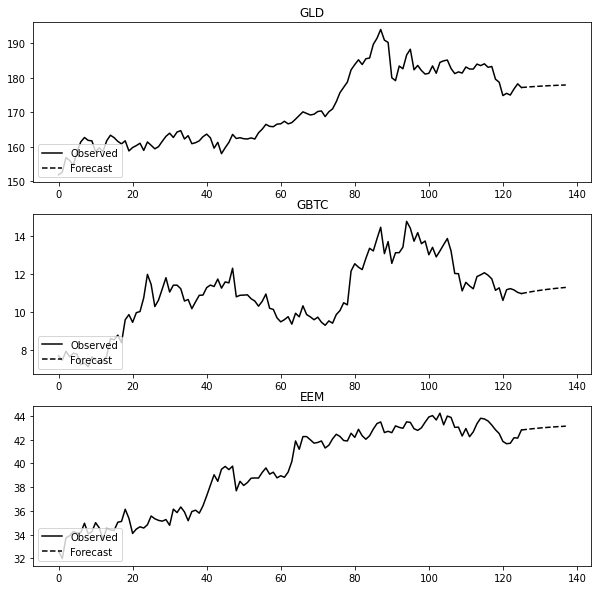

In [253]:
model_res.plot_forecast(steps=12, plot_conf_int=False)

Q4 forecast

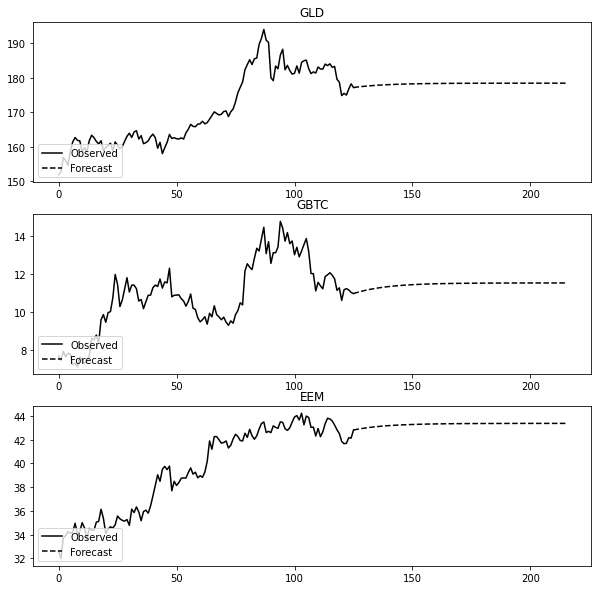

In [254]:
model_res.plot_forecast(steps=90, plot_conf_int=False)

The model doesn't perform well, given the lack of training data and cointegration relationship between the variables

#### VAR forecast

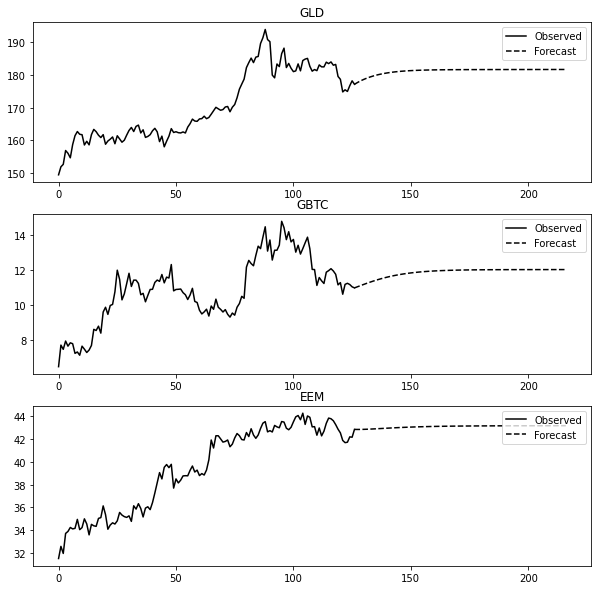

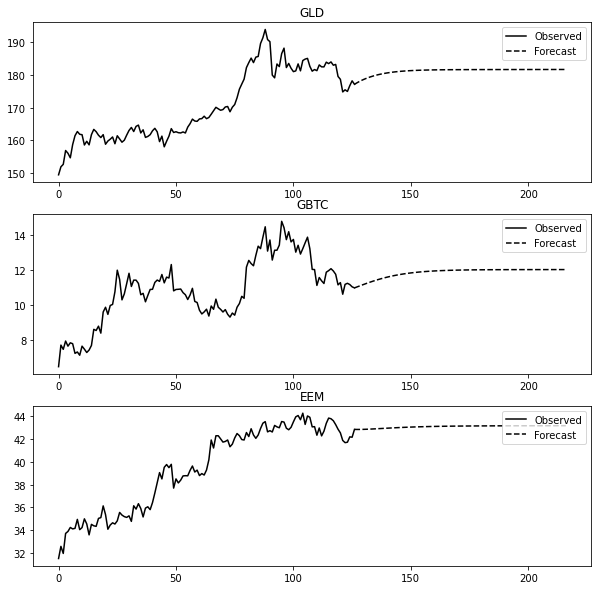

In [259]:
from statsmodels.tsa.api import VAR
model = VAR(data)
model_VAR = model.fit()
model_VAR.plot_forecast(steps=90, plot_stderr= False)

Similarly, The model doesn't perform well, given the lack of training data and cointegration relationship between the variables

### Step 8: Correlation vs Cointegration

Correlation does not have a direction i.e.: $ corr(r_1,r_2) = corr(r_2,r_1) $. This is because to calculate coefficient, we normalize covarience the against the deviation standards of both $ r_1 $  and $ r_2 $.

Linear regression has direction i.e. the slope and intercept are different depending on the series we consider as the regressor variable. In this case, to calculate the slope, we normalize the covariance against the variance of the regressor and not noth of the variables.

Cointegration also has direction. This is because the coefficients that makes the linear combination of two variables that stationary cannot be interchanged to reach the same conclusion.

### Work Cited
Gray, K. L. (2007). Comparison of trend detection methods. University of Montana.  
 Pesaran, M.H.; Shin, Y.; Smith, R.J. (2001). "Bounds testing approaches to the analysis of level relationships". Journal of Applied Econometrics. 16 (3): 289–326. doi:10.1002/jae.616. hdl:10983/25617.